## Libraries

In [1]:
import pandas as pd
import numpy as np
import math

# Visualization
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import RobustScaler, MinMaxScaler
from sklearn.model_selection import train_test_split, GridSearchCV

import category_encoders as ce
from sklearn.preprocessing import TargetEncoder

from sklearn.dummy import DummyRegressor

# model regressor
from sklearn.svm import SVR
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from xgboost import XGBRegressor
from sklearn.neural_network import MLPRegressor

# Model evaluation
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error  
from sklearn.metrics import r2_score

In [62]:
# from sklearn.feature_extraction import FeatureHasher


In [2]:
# Prevent warnings from showing up
import warnings
warnings.filterwarnings("ignore")

In [3]:
# Set Random seed for reproducibility
np.random.seed(12712)

In [4]:
# Set Seaborn plot style and default colors
sns.set_style(style="whitegrid")
sns.set_color_codes(palette="deep")  

## Data

In [5]:
# Import the property dataset
mdl_df = pd.read_csv("data/model_house_price.csv")
mdl_df.head()

,bedrooms,bathrooms,toilets,parking_space,type,town,state,geo_zone,GDP_per_capital,total_crime,price_wins
0,6,5,5,4,Detached Duplex,Mabushi,Abuja,North Central,1292.0,5382,450000000.0
1,4,5,5,4,Terraced Duplexes,Katampe,Abuja,North Central,1292.0,5382,650000000.0
2,4,5,5,4,Detached Duplex,Lekki,Lagos,South West,6614.0,50975,120000000.0
3,4,4,5,6,Detached Duplex,Ajah,Lagos,South West,6614.0,50975,40000000.0
4,4,4,5,2,Semi Detached Duplex,Lekki,Lagos,South West,6614.0,50975,75000000.0


In [6]:
# A quick information about the dataset
mdl_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13888 entries, 0 to 13887
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   bedrooms         13888 non-null  int64  
 1   bathrooms        13888 non-null  int64  
 2   toilets          13888 non-null  int64  
 3   parking_space    13888 non-null  int64  
 4   type             13888 non-null  object 
 5   town             13888 non-null  object 
 6   state            13888 non-null  object 
 7   geo_zone         13888 non-null  object 
 8   GDP_per_capital  13888 non-null  float64
 9   total_crime      13888 non-null  int64  
 10  price_wins       13888 non-null  float64
dtypes: float64(2), int64(5), object(4)
memory usage: 1.2+ MB


## Split data

In [7]:
# Split dataset into target & and features
X = mdl_df.drop(["price_wins", "state"], axis=1)
y = mdl_df["price_wins"]

## Feature Engineering

In [8]:
def one_hot_encoder(df, feature):
    """ """
    data = df.copy()
    # One-hot encode the column
    one_hot_features = pd.get_dummies(data[feature], prefix=feature)

    # Convert to 1 and 0s
    for cols in one_hot_features.columns:
        one_hot_features[cols] = one_hot_features[cols].astype("int64")

    # Join the one-hot encoded columns with the original dataframe
    data = data.join(one_hot_features)

    # Drop the original feature column
    data = data.drop(feature, axis=1)

    return data

In [9]:
X = one_hot_encoder(X, "type")
X = one_hot_encoder(X, "geo_zone")

In [10]:
# Initially split samples into train 80% and test 20%
X_all_train, X_test, y_all_train, y_test = train_test_split(X, y, test_size=0.2, random_state=12)
# Perform another split on the train set (.._all_train) & allocate 80% to train set and 20% to validation set.
X_train, X_val, y_train, y_val = train_test_split(X_all_train, y_all_train, test_size=0.2, random_state=12)

In [11]:
# Print out data dimentions
print(f"ALL Train set shape: X = {X_all_train.shape} | y = {y_all_train.shape}\n")
print(f"Train set shape: X = {X_train.shape} | y = {y_train.shape}\n")
print(f"validation set shape: X =  {X_val.shape} | y = {y_val.shape}\n")
print(f"Test set shape: X =  {X_test.shape} | y = {y_test.shape}")

ALL Train set shape: X = (11110, 20) | y = (11110,)

Train set shape: X = (8888, 20) | y = (8888,)

validation set shape: X =  (2222, 20) | y = (2222,)

Test set shape: X =  (2778, 20) | y = (2778,)


### Target Encoder (town)

In [12]:
# Initialize a target encoder with a smooth value of 5000.0 and fit it on the all train set
te = TargetEncoder(smooth=10000.0)
te.fit(X_all_train[["town"]], y_all_train)

TargetEncoder(smooth=10000.0)

In [13]:
# Transform the various feature slice using the fitted target encoder
X_all_train["town"] = te.transform(X_all_train[["town"]])
X_train["town"] = te.transform(X_train[["town"]])
X_val["town"] = te.transform(X_val[["town"]])

### Numeric features Normalization

In [14]:
# Collect all numeric column names
num_cols = list(X_all_train.select_dtypes(["int64", "float64"]).columns)

# Initialize and fit min max scaler on the all train set
mm_scaler = MinMaxScaler()
mm_scaler.fit(X_all_train[num_cols])

MinMaxScaler()

In [15]:
# Transform the various feature slice using the fitted min max scaler
X_all_train[num_cols] = mm_scaler.transform(X_all_train[num_cols])
X_train[num_cols] = mm_scaler.transform(X_train[num_cols])
X_val[num_cols] = mm_scaler.transform(X_val[num_cols])

## Correlation analysis

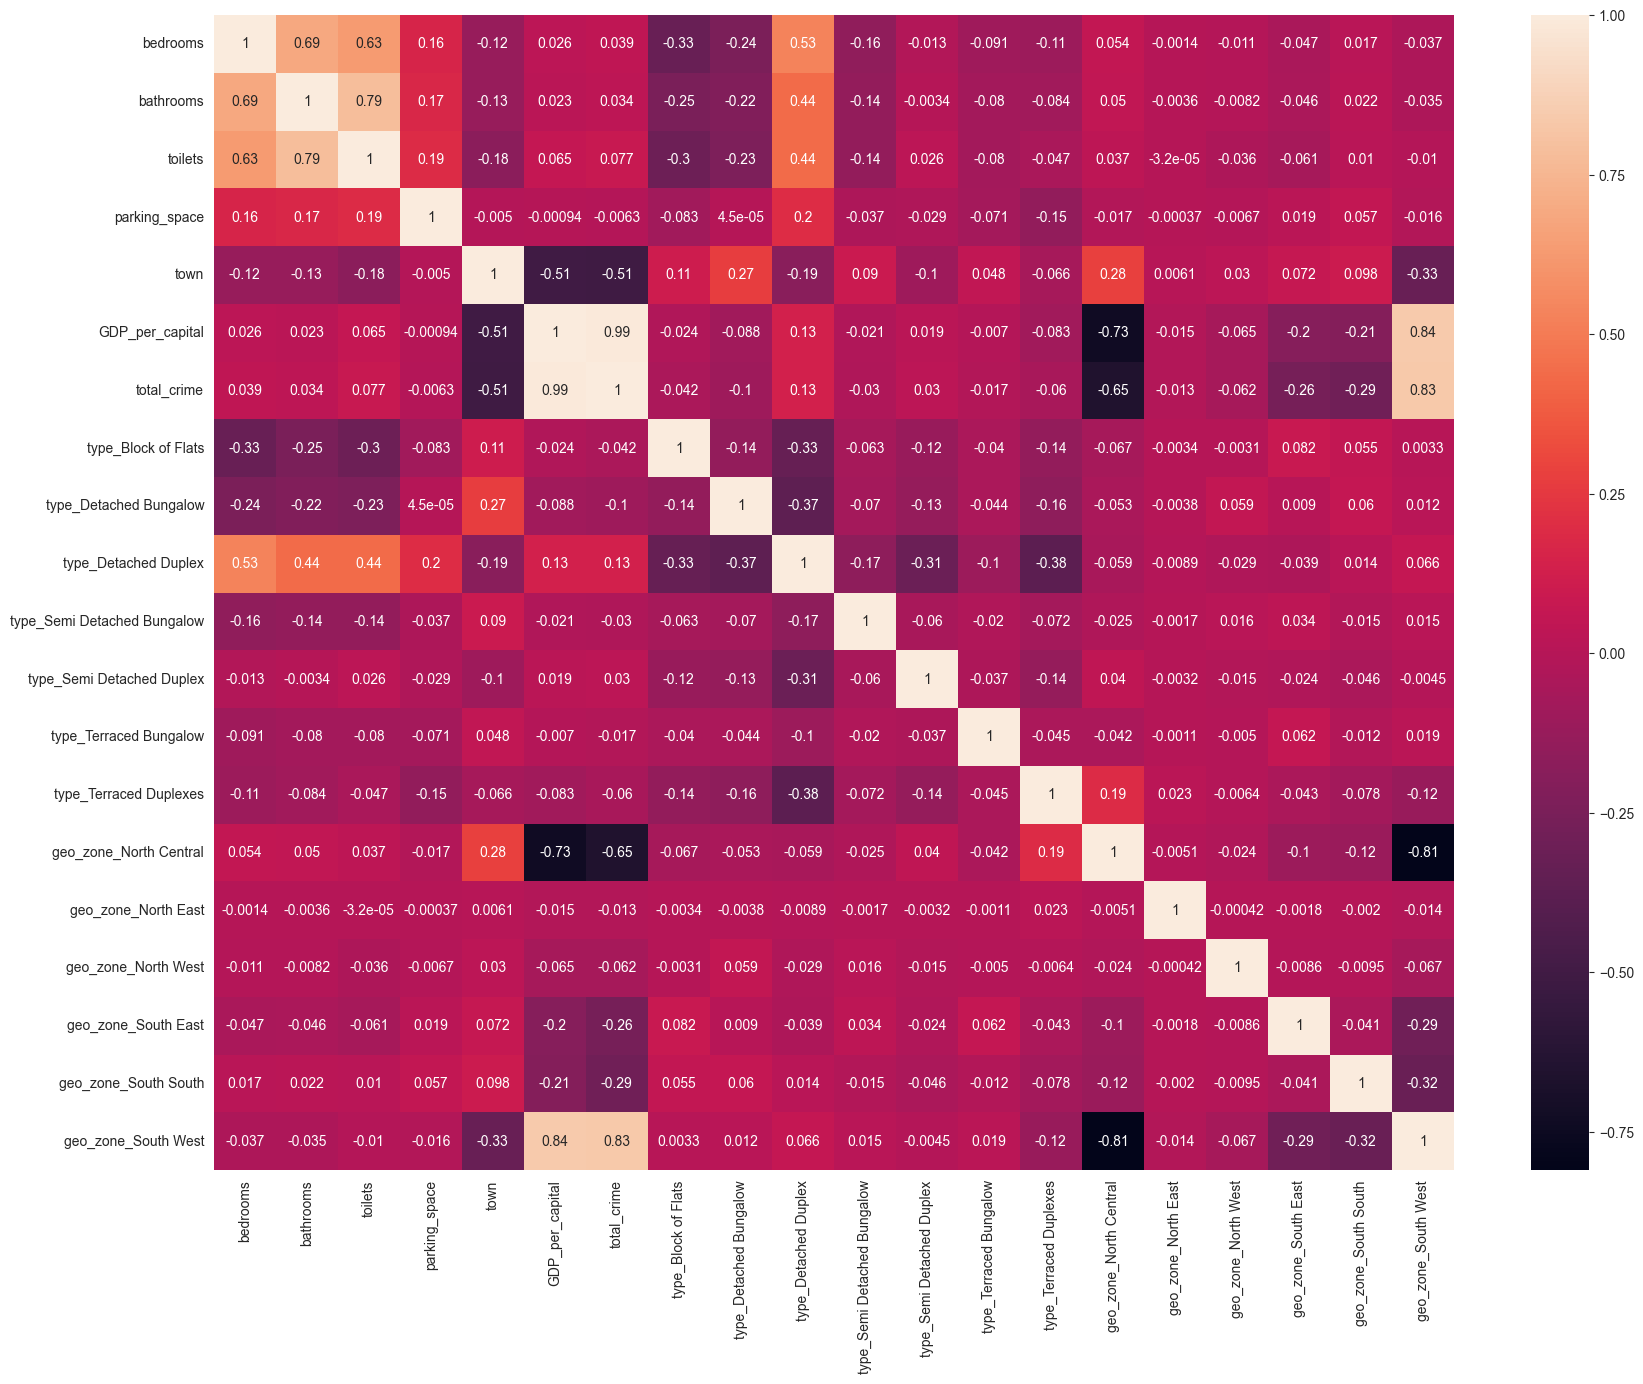

In [83]:
plt.figure(figsize=(20, 15))
cor = X_all_train.select_dtypes(["int64", "float64"]).corr()
sns.heatmap(cor, annot=True)
plt.show()

## Model Training

In [16]:
bar_color = "#0FA3B1"

In [17]:
def adjusted_R2(R2, X_val_set):
    """ """
    # Number of observations
    n = X_val_set.shape[0]
    # Number of features
    p = X_val_set.shape[1]

    # Calculate Adjusted R2
    adjusted_r2 = 1 - (1 - R2) * (n - 1) / (n - p - 1)

    return adjusted_r2

### Using Default Parameters

In [79]:
train_regressors = {
    "Linear Regression": LinearRegression(),
    "SVR": SVR(kernel="linear"),
    "Decision Tree": DecisionTreeRegressor(),
    "Random Forest": RandomForestRegressor(),
    "Gradient Boosting": GradientBoostingRegressor(),
    "ANN": MLPRegressor(hidden_layer_sizes=(50, 50)),
    "Xgboost": XGBRegressor()
}

In [80]:
init_mdl_run = {}

for mdl_name, mdl in train_regressors.items():
    # Print out regression model name
    print(mdl_name)
    print("-"*50)

    # Fit model using the train set
    mdl.fit(X_train, y_train)
    # Make prediction using the validation set
    mdl_y_pred = mdl.predict(X_val)

    # Collect the evaluation metrics
    r2  = r2_score(y_val, mdl_y_pred)
    adj_r2 = adjusted_R2(r2, X_val)
    mae = mean_absolute_error(y_val, mdl_y_pred)

    # Store evaluation metrics
    init_mdl_run[mdl_name] = {
        "r2": r2,
        "adjusted_r2": adj_r2,
        "mae": mae
    }

    # Print out evaluation metrics
    print(f"R-Squared (r2): {r2}")
    print(f"Adjusted R-Squared: {adj_r2}")
    print(f"Mean Absolute Error (MAE): {mae}")
    print("="*50)
    print("\n")

Linear Regression
--------------------------------------------------
R-Squared (r2): 0.24441992242788646
Adjusted R-Squared: 0.23755413344495047
Mean Absolute Error (MAE): 96360284.59945995


SVR
--------------------------------------------------
R-Squared (r2): -0.15162529247683754
Adjusted R-Squared: -0.1620898566974358
Mean Absolute Error (MAE): 97906621.89716306


Decision Tree
--------------------------------------------------
R-Squared (r2): 0.4686274499740313
Adjusted R-Squared: 0.4637989851850629
Mean Absolute Error (MAE): 64537436.50594236


Random Forest
--------------------------------------------------
R-Squared (r2): 0.5893841919999108
Adjusted R-Squared: 0.5856530170067251
Mean Absolute Error (MAE): 60525216.64494537


Gradient Boosting
--------------------------------------------------
R-Squared (r2): 0.6303781800920971
Adjusted R-Squared: 0.6270195083982497
Mean Absolute Error (MAE): 60936345.41278985


ANN
--------------------------------------------------
R-Squared (r

In [20]:
init_mdl_run

{'Linear Regression': {'r2': 0.24441992242788646,
  'adjusted_r2': 0.23755413344495047,
  'mae': 96360284.59945995,
  'rmse': 139023992.77570546},
 'SVR': {'r2': -0.15162529247683754,
  'adjusted_r2': -0.1620898566974358,
  'mae': 97906621.89716306,
  'rmse': 171634704.00118256},
 'Decision Tree': {'r2': 0.4624919470315738,
  'adjusted_r2': 0.4576077302849275,
  'mae': 64653616.69538988,
  'rmse': 117257868.61001842},
 'Random Forest': {'r2': 0.586092449741537,
  'adjusted_r2': 0.5823313634147904,
  'mae': 60906291.70635561,
  'rmse': 102896637.38621943},
 'Gradient Boosting': {'r2': 0.6303760928583737,
  'adjusted_r2': 0.6270174021982953,
  'mae': 60936053.71024309,
  'rmse': 97236548.52541451},
 'ANN': {'r2': -0.5996574483183235,
  'adjusted_r2': -0.6141931816060866,
  'mae': 124577728.36832072,
  'rmse': 202284685.40877905},
 'Xgboost': {'r2': 0.6206502779167398,
  'adjusted_r2': 0.6172032109282504,
  'mae': 59037024.285834834,
  'rmse': 98507521.75546284}}

In [21]:
# Baseline model
# y_average = y_train.mean()

# baseline_y_pred = [y_average]*len(y_train)

# base_r_squared = r2_score(y_train, baseline_y_pred)
# base_mae = mean_absolute_error(y_train, baseline_y_pred)
# base_rmse = np.sqrt(mean_squared_error(y_train, baseline_y_pred))

# print(f"Average (mean) price: {y_average:.2f}")
# print(f"R2: {base_r_squared}")
# print(f"MAE: {base_mae}")

Average (mean) price: 139849718.01
R2: 0.0
MAE: 116664048.27514054
RMAE: 164706691.4822259


In [72]:
dummy_reg = DummyRegressor(strategy="mean")

dummy_reg.fit(X_train, y_train)

dummy_y_pred = dummy_reg.predict(X_val)

base_r_squared = r2_score(y_val, dummy_y_pred)
base_adj_r_squared = adjusted_R2(base_r_squared, X_val)
base_mae = mean_absolute_error(y_val, dummy_y_pred)
base_rmse = np.sqrt(mean_squared_error(y_val, dummy_y_pred))

print(f"R2: {base_r_squared}")
print(f"Adjusted R2: {base_adj_r_squared}")
print(f"MAE: {base_mae}")

R2: -0.00025856160162751607
Adjusted R2: -0.009347689830629058
MAE: 112932712.11876814


#### Summary

In [74]:
names, r2_vals, adj_r2_vals, mae_vals = [], [], [], []

for mdl_name in train_regressors.keys():
    names.append(mdl_name)
    r2_vals.append(init_mdl_run[mdl_name]["r2"])
    adj_r2_vals.append(init_mdl_run[mdl_name]["adjusted_r2"])
    mae_vals.append(init_mdl_run[mdl_name]["mae"])

init_mdl_performance = pd.DataFrame({
    "model": names,
    "R2": r2_vals,
    "adj_R2": adj_r2_vals,
    "MAE":  mae_vals
})

init_mdl_performance

,model,R2,adj_R2,MAE
0,Linear Regression,0.244420,0.237554,9.636028e+07
1,SVR,-0.151625,-0.162090,9.790662e+07
2,Decision Tree,0.462492,0.457608,6.465362e+07
3,Random Forest,0.586092,0.582331,6.090629e+07
4,Gradient Boosting,0.630376,0.627017,6.093605e+07
5,ANN,-0.599657,-0.614193,1.245777e+08
6,Xgboost,0.620650,0.617203,5.903702e+07


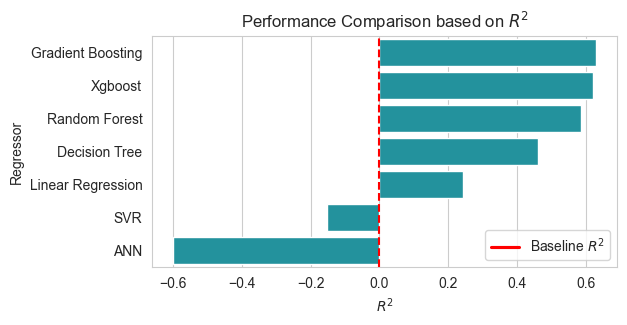

In [119]:
plt.figure(figsize=(6, 3))
ax = sns.barplot(data=init_mdl_performance.sort_values(by="R2", ascending=False), x="R2", y="model", color=bar_color)
ax.axvline(base_r_squared, color="red", linestyle="--")
plt.title("Performance Comparison based on $R^2$")
plt.xlabel(r'$R^2$')
plt.ylabel("Regressor")
plt_legend = plt.legend(["Baseline $R^2$"], loc="lower right")
plt_legend.legend_handles[0].set_color("red")
# Save plot
plt.savefig('images/init_mdls_R_squared.png', bbox_inches="tight") 
plt.show()

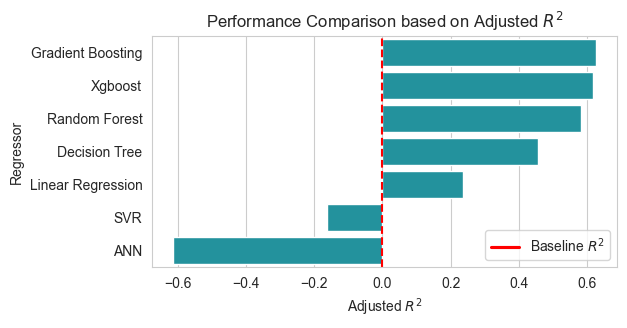

In [120]:
plt.figure(figsize=(6, 3))
ax = sns.barplot(data=init_mdl_performance.sort_values(by="adj_R2", ascending=False), x="adj_R2", y="model", color=bar_color)
ax.axvline(base_r_squared, color="red", linestyle="--")
plt.title("Performance Comparison based on Adjusted $R^2$")
plt.xlabel("Adjusted $R^2$")
plt.ylabel("Regressor")
plt_legend = plt.legend(["Baseline $R^2$"], loc="lower right")
plt_legend.legend_handles[0].set_color("red")
# Save plot
plt.savefig('images/init_mdls_adj_R_squared.png', bbox_inches="tight") 
plt.show()

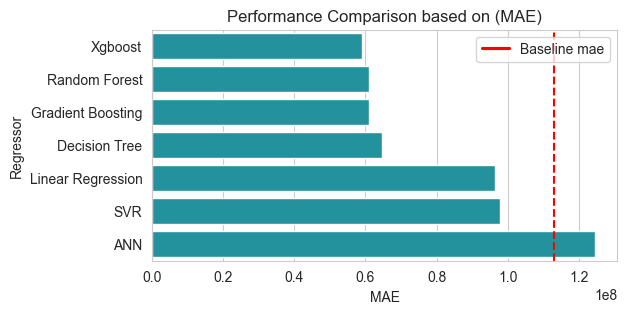

In [121]:
plt.figure(figsize=(6, 3))
ax = sns.barplot(data=init_mdl_performance.sort_values(by="MAE", ascending=True), x="MAE", y="model", color=bar_color)
ax.axvline(base_mae, color="red", linestyle="--")
plt.title("Performance Comparison based on (MAE)")
plt.ylabel("Regressor")
plt_legend = plt.legend(["Baseline mae"], loc="upper right")
plt_legend.legend_handles[0].set_color("red")
# Save plot
plt.savefig('images/init_mdls_mae.png', bbox_inches="tight") 
plt.show()

In [77]:
# plt.figure(figsize=(6, 4))
# ax = sns.barplot(data=init_mdl_performance.sort_values(by="RMSE", ascending=True), x="RMSE", y="model", color=bar_color)
# ax.axvline(base_rmse, color="red", linestyle="--")
# plt.title("Model Performance based on (RMSE)")
# # Save plot 
# plt_legend = plt.legend(["Baseline R2"], loc="upper right")
# plt_legend.legend_handles[0].set_color("red")
# plt.savefig('images/init_mdls_rmse.png') 
# plt.show()

- Random Forest
- Gradient Boosting
- Xgboost

### Tune Model Hyperparameter

#### Random Forest

In [35]:
rf_params = {
    "n_estimators": [300, 500],
    "max_depth": [None, 10, 12],
    "min_samples_split": [2, 10],
    "min_samples_leaf": [1, 5]
}

rf_grid_search = GridSearchCV(
    RandomForestRegressor(random_state=12), rf_params, cv=5, scoring="neg_mean_absolute_error", n_jobs=-1
)

rf_grid_search.fit(X_all_train, y_all_train)

print(f"Best Random Forest Params: {rf_grid_search.best_params_}")
print(f"Best Score {-rf_grid_search.best_score_}")

Best Random Forest Params: {'max_depth': 12, 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 500}
Best Score 57474621.24562107


In [37]:
rf_grid_search.cv_results_["mean_test_score"]

array([-59337217.91475406, -59312948.48898606, -57711528.04623184,
       -57691024.70154245, -57689692.88774838, -57628980.20712606,
       -57689692.88774838, -57628980.20712606, -57968434.36802514,
       -57944021.69576405, -58019576.78215283, -58001999.45223147,
       -58298863.31786768, -58252679.64412347, -58298863.31786768,
       -58252679.64412347, -57670222.13375252, -57650326.3872932 ,
       -57504908.06977757, -57474621.24562107, -57881761.09307101,
       -57822747.6522191 , -57881761.09307101, -57822747.6522191 ])

In [40]:
# rf_grid_search.cv_results_.keys()
rf_grid_search.cv_results_["params"]

[{'max_depth': None,
  'min_samples_leaf': 1,
  'min_samples_split': 2,
  'n_estimators': 300},
 {'max_depth': None,
  'min_samples_leaf': 1,
  'min_samples_split': 2,
  'n_estimators': 500},
 {'max_depth': None,
  'min_samples_leaf': 1,
  'min_samples_split': 10,
  'n_estimators': 300},
 {'max_depth': None,
  'min_samples_leaf': 1,
  'min_samples_split': 10,
  'n_estimators': 500},
 {'max_depth': None,
  'min_samples_leaf': 5,
  'min_samples_split': 2,
  'n_estimators': 300},
 {'max_depth': None,
  'min_samples_leaf': 5,
  'min_samples_split': 2,
  'n_estimators': 500},
 {'max_depth': None,
  'min_samples_leaf': 5,
  'min_samples_split': 10,
  'n_estimators': 300},
 {'max_depth': None,
  'min_samples_leaf': 5,
  'min_samples_split': 10,
  'n_estimators': 500},
 {'max_depth': 10,
  'min_samples_leaf': 1,
  'min_samples_split': 2,
  'n_estimators': 300},
 {'max_depth': 10,
  'min_samples_leaf': 1,
  'min_samples_split': 2,
  'n_estimators': 500},
 {'max_depth': 10,
  'min_samples_leaf':

##### Feature Importance

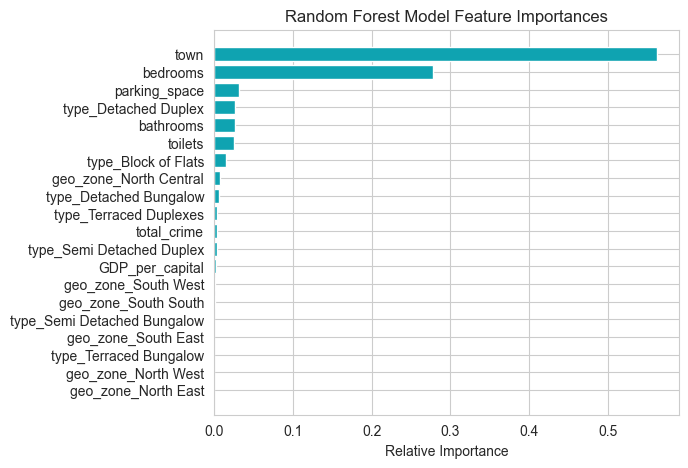

In [41]:
# Column names of all features
features = X_all_train.columns

# Relative importance of all feature
importances = rf_grid_search.best_estimator_.feature_importances_
indices = np.argsort(importances)

# Plot an horizontal bar chart of the features
fig, ax = plt.subplots(figsize=(6, 5))
plt.barh(range(len(indices)), importances[indices], color=bar_color, align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.title(f'Random Forest Model Feature Importances')
plt.xlabel('Relative Importance')
# Save the plot as an image
plt.savefig('images/rf_feature_importance.png')
plt.show()

#### Gradient Boosting

In [43]:
gb_params = {
    "n_estimators": [100, 200, 300],
    "learning_rate": [0.01, 0.05, 0.1],
    "max_depth": [5, 7],
    "min_samples_split": [2, 10],
    "alpha": [0.5, 0.8]
}

gb_grid_search = GridSearchCV(
    GradientBoostingRegressor(), gb_params, cv=5, scoring="neg_mean_absolute_error", n_jobs=-1
)
gb_grid_search.fit(X_all_train, y_all_train)

print(f"Best Gradient Boosting Params: {gb_grid_search.best_params_}")
print(f"Best Score {-gb_grid_search.best_score_}")

Best Gradient Boosting Params: {'alpha': 0.5, 'learning_rate': 0.05, 'max_depth': 7, 'min_samples_split': 10, 'n_estimators': 200}
Best Score 56792157.322280005


##### Feaure Importance

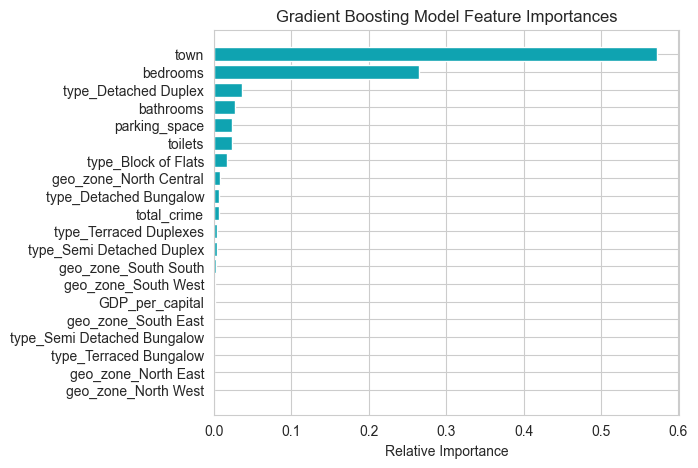

In [44]:
# Column names of all features
features = X_all_train.columns

# Relative importance of all feature
importances = gb_grid_search.best_estimator_.feature_importances_
indices = np.argsort(importances)

# Plot an horizontal bar chart of the features
fig, ax = plt.subplots(figsize=(6, 5))
plt.barh(range(len(indices)), importances[indices], color=bar_color, align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.title(f'Gradient Boosting Model Feature Importances')
plt.xlabel('Relative Importance')
# Save the plot as an image
plt.savefig('images/gb_feature_importance.png')
plt.show()

#### Xgboost

In [45]:
xgb_params = {
    "max_depth": [3, 5, 7],
    "learning_rate": [0.01, 0.05, 0.1],
    "n_estimators": [50, 100, 200],
    "gamma": [0, 0.1, 0.5],
    "colsample_bytree": [0.5, 1]
}

xgb_grid_search = GridSearchCV(XGBRegressor(), xgb_params, cv=5, scoring="neg_mean_absolute_error", n_jobs=-1)
xgb_grid_search.fit(X_all_train, y_all_train)

print(f"Best Xgboost Params: {xgb_grid_search.best_params_}")
print(f"Best Score {-xgb_grid_search.best_score_}")

Best Xgboost Params: {'colsample_bytree': 1, 'gamma': 0, 'learning_rate': 0.05, 'max_depth': 7, 'n_estimators': 200}
Best Score 56721920.062256694


In [48]:
from xgboost import plot_importance

In [49]:
xgb = XGBRegressor(
    n_estimators=xgb_grid_search.best_params_["n_estimators"],
    max_depth=xgb_grid_search.best_params_["max_depth"],
    learning_rate=xgb_grid_search.best_params_["learning_rate"],
    gamma=xgb_grid_search.best_params_["gamma"],
    colsample_bytree=xgb_grid_search.best_params_["colsample_bytree"],
    random_state=12
)

xgb.fit(X_train, y_train)
xgb_y_pred = xgb.predict(X_val)

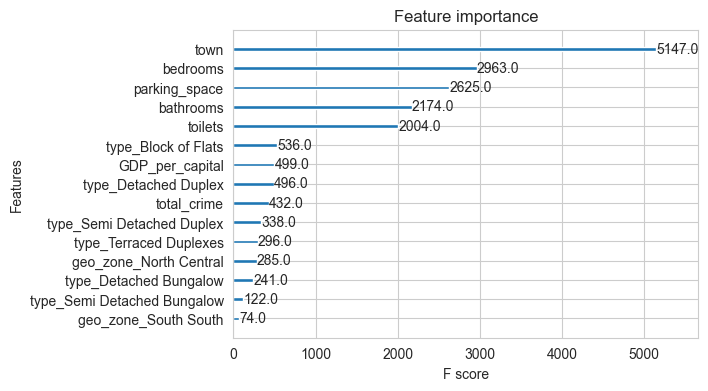

In [124]:
fig, ax = plt.subplots(figsize=(6, 4))
plot_importance(xgb, max_num_features=15, ax=ax)
# Save the plot as an image
plt.savefig('images/xgb_feature_importance.png', bbox_inches="tight") 
plt.show()

#### Summary

In [51]:
temp = pd.DataFrame({
    "model": ["Random Forest", "Gradient Boosting", "Xgboost"],
    "MAE": [
        -rf_grid_search.best_score_, 
        -gb_grid_search.best_score_, 
        -xgb_grid_search.best_score_
    ]
}).sort_values(by="MAE")

temp

,model,MAE
2,Xgboost,5.672192e+07
1,Gradient Boosting,5.679216e+07
0,Random Forest,5.747462e+07


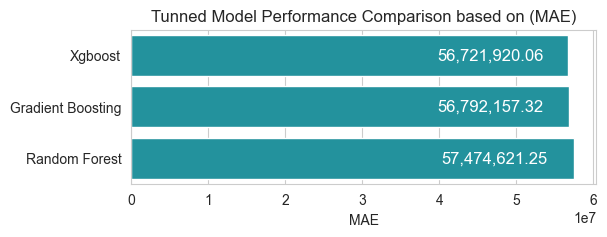

In [123]:
plt.figure(figsize=(6, 2))
ax = sns.barplot(data=temp, x="MAE", y="model", color=bar_color)
for p in ax.patches:
    width = p.get_width()
    ax.text(width - 0.3 * width, p.get_y() + p.get_height() / 2, f"{width:,.2f}", va="center", color="white", size=12) 
plt.title("Tunned Model Performance Comparison based on (MAE)")
plt.ylabel("")
# Save the plot as an image
plt.savefig('images/tunned_mdls_mae.png', bbox_inches="tight") 
plt.show()

# Add values with comma

## Top Model Training/prediction/evaluation

- Final training & testing
- Evaluation (MAE, R2, RMSE)
- Predicted vs actual (relationship plot)
- Error/residual plots

### Feature Engineer Test dataset

In [58]:
## Get X_test data


# X_test = target_encoder.transform(X_test, y_test)
X_test["town"] = te.transform(X_test[["town"]])

num_cols = list(X_test.select_dtypes(["int64", "float64"]).columns)
X_test[num_cols] = mm_scaler.transform(X_test[num_cols])

### Prediction

In [59]:
gb_mdl = gb_grid_search.best_estimator_
gb_mdl

GradientBoostingRegressor(alpha=0.5, learning_rate=0.05, max_depth=7,
                          min_samples_split=10, n_estimators=200)

In [60]:
xgb_mdl = xgb_grid_search.best_estimator_
xgb_mdl

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None, colsample_bytree=1,
             device=None, early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, feature_types=None, gamma=0, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.05, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=7,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=200,
             n_jobs=None, num_parallel_tree=None, random_state=None, ...)

In [61]:
gb_y_pred = gb_mdl.predict(X_test)

In [62]:
xgb_y_pred = xgb_mdl.predict(X_test)

### Evaluation

#### Metrics

##### GB

In [63]:
r2  = r2_score(y_test, gb_y_pred)
adj_r2 = adjusted_R2(r2, X_test)
mae = mean_absolute_error(y_test, gb_y_pred)
rmse = np.sqrt(mean_squared_error(y_test, gb_y_pred))

print(f"R-squared: {r2:.3f}")
print(f"Adjusted R-squared: {adj_r2:.3f}")
print(f"MAE: {mae:,.2f}")
# print(f"RMSE: {rmse:,.2f}")

R-squared: 0.688
Adjusted R-squared: 0.686
MAE: 51,895,335.89
RMSE: 87,262,011.49


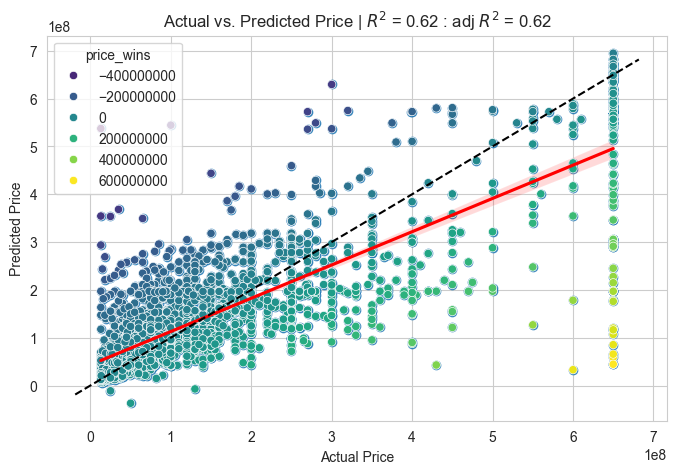

In [88]:
plt.figure(figsize=(8, 5))

# Create the scatter plot with regression line
sns.regplot(x=y_test, y=gb_y_pred, line_kws={'color': 'red'})

# Add a diagonal line for perfect prediction (y = x)
plt.plot(plt.xlim(), plt.xlim(), color='black', linestyle='--')

plt.xlabel('Actual Price')
plt.ylabel('Predicted Price')
plt.title(
    f'Actual vs. Predicted Price | $R^2$ = {round(r2, 2)} : adj $R^2$ = {round(adj_r2, 2)}'
)
plt.grid(True) 

# Add color-coding based on residuals (error)
sns.scatterplot(x=y_test, y=gb_y_pred, hue=y_test-gb_y_pred, palette='vlag')

# Save the plot as an image
# plt.savefig('images/gb_actual_vs_predicted_price.png')  
plt.show()

##### XGboost

In [125]:
r2  = r2_score(y_test, xgb_y_pred)
adj_r2 = adjusted_R2(r2, X_test)
mae = mean_absolute_error(y_test, xgb_y_pred)
rmse = np.sqrt(mean_squared_error(y_test, xgb_y_pred))

print(f"R-squared: {r2:.3f}")
print(f"Adjusted R-squared: {adj_r2:.3f}")
print(f"MAE: {mae:,.2f}")

R-squared: 0.691
Adjusted R-squared: 0.688
MAE: 51,620,691.01


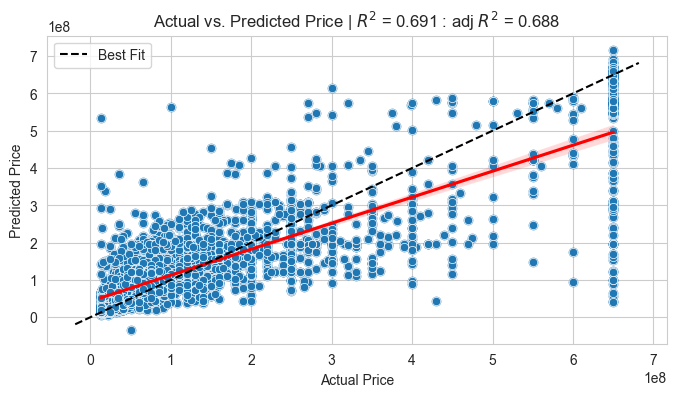

In [126]:
plt.figure(figsize=(8, 4))

# Create the scatter plot with regression line
sns.regplot(x=y_test, y=xgb_y_pred, line_kws={'color': 'red'})

# Add a diagonal line for perfect prediction (y = x)
plt.plot(plt.xlim(), plt.xlim(), color='black', linestyle='--', label="Best Fit")

plt.xlabel('Actual Price')
plt.ylabel('Predicted Price')
plt.title(
    f'Actual vs. Predicted Price | $R^2$ = {round(r2, 3)} : adj $R^2$ = {round(adj_r2, 3)}'
)
plt.grid(True) 

# Add color-coding based on residuals (error)
sns.scatterplot(x=y_test, y=xgb_y_pred, palette='viridis')
plt.legend()
# plt_legend = plt.legend(["Regression line"], loc="upper left")
# plt_legend.legend_handles[0].set_color("red")
# Save the plot as an image
plt.savefig('images/xgb_actual_vs_predicted_price.png')  
plt.show()